# Udacity Deep Reinforcement Learning Nanodegree - Project 2: Continuous Control

In [1]:
from collections import deque
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
from unityagents import UnityEnvironment

from agent import Agent

## Set everything up
* Parameters
* Unity environment
* Agent

## Parameters

In [2]:
params = {
    'buffer_size': 5e5,
    'batch_size': 512,
    'n_episodes': 200,
    'max_t': 1000,
    'update_step': 10,
    'solution_threshold': 30.,
    'eval_window_length': 100,
    'num_agents': 20,
    'agent_seed': 32,
    'env_seed': 32,
    'gamma': 0.99,
    'tau': 1e-3,
    'lr_actor': 3e-4,
    'lr_critic': 1e-3,
    'critic_weight_decay': 0
}

In [3]:
env = UnityEnvironment(file_name='Reacher.app',
                       seed=params['env_seed'],
                       no_graphics=True)
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


## Instantiate DDPG Agent

In [4]:
state_size = env.reset(train_mode=False)[brain_name].vector_observations[0].shape[0]
action_size = brain.vector_action_space_size

agent = Agent(state_size=state_size,
              action_size=action_size,
              params=params)

## Train the Agent with DDPG (Deep Deterministic Policy Gradients)

In [5]:
def perform_ddpg_training(env, brain_name, agent, params):
    """
    Performs Deep Deterministic Policy Gradients Algorithm
    according to
    https://arxiv.org/pdf/1509.02971.pdf
    
    Args:
        env (:obj:`UnityEnvironment`): Environment for agent(s) to act in
            and to obtain observations (states) and rewards from
        brain_name (str): name of the environment control brain
        agent (:obj:`Agent.agent`): DDPG agent, i.e. actor and critic networks
            as local and target versions)
        params (dict): hyperparameters for instatiation, training and evaluation
        
    Returns:
        avg_scores (list(float)): list of episode-wise scores averaged across agents
    """
    eval_window_length = params['eval_window_length']
    env_is_solved = False
    avg_scores = []
    scores_window = deque(maxlen=eval_window_length)
    best_avg_agent_score = 0
    
    for i_episode in range(1, params['n_episodes']+1):
        start = time.time()
        agent.reset()
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent_scores = np.zeros(params['num_agents'])
        
        for t in range(params['max_t']):
            actions = agent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done)
            
            states = next_states
            agent_scores += rewards
        
        avg_agent_score = np.mean(agent_scores)
        avg_scores.append(avg_agent_score)
        np.save('avg_scores', avg_scores)
        scores_window.append(avg_agent_score)
        duration = int(time.time() - start)
        
        print('\rEpisode {} - {} [s]\tAverage Score: {:.2f}'.format(
            i_episode, duration, avg_agent_score), end="")
        
        if i_episode % params['eval_window_length'] == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            
        if (np.mean(scores_window) >= params['solution_threshold']) & (not env_is_solved):
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode,
                                                                                         np.mean(scores_window)))
            env_is_solved = True
        
        # Save best agents
        if env_is_solved & (avg_agent_score > best_avg_agent_score):
            best_avg_agent_score = avg_agent_score
            torch.save(agent.actor_local.state_dict(), 'best_actor_e_{}.pth'.format(i_episode))
            torch.save(agent.critic_local.state_dict(), 'best_critic_e_{}.pth'.format(i_episode))
            
    return avg_scores

In [18]:
avg_scores = perform_ddpg_training(env, brain_name, agent, params)
env.close()

Episode 67 - 85 [s]	Average Score: 38.43
Environment solved in 67 episodes!	Average Score: 30.03
Episode 100	Average Score: 32.52
Episode 200	Average Score: 36.64


## Performance Plot

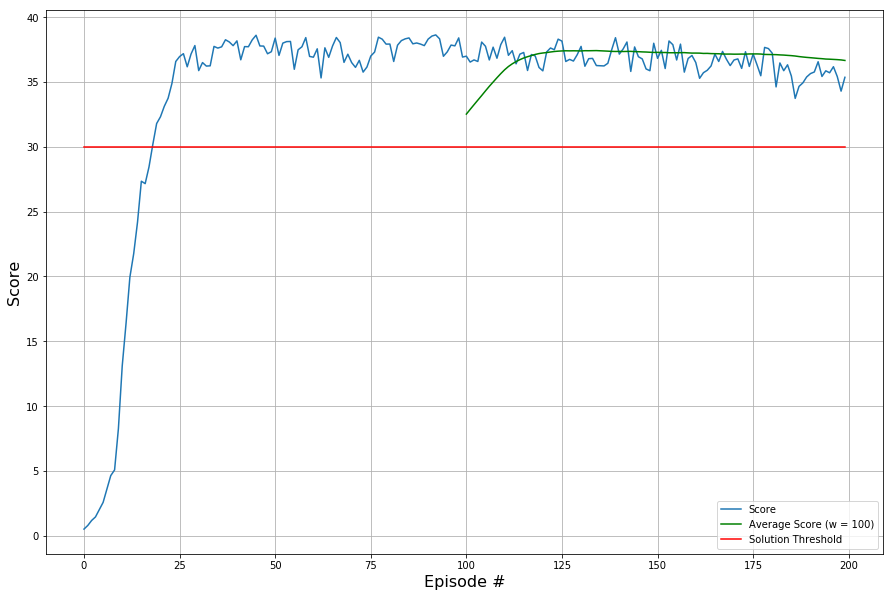

In [10]:
average_scores = np.array([np.mean(avg_scores[i:(i+params['eval_window_length'])])
                           for i in range(len(avg_scores)-params['eval_window_length'])])
steps = len(avg_scores)

fig = plt.figure(figsize=(15, 10))
plt.plot(np.arange(steps), avg_scores, linewidth=1.5)
plt.plot(np.arange(params['eval_window_length'], steps), average_scores, 'g-')
plt.plot(np.arange(steps), [params['solution_threshold']]*steps, 'r-')
plt.ylabel('Score', fontsize=16)
plt.xlabel('Episode #', fontsize=16)
plt.legend(['Score', 'Average Score (w = 100)', 'Solution Threshold'])
plt.grid(True)
plt.show()

In [19]:
print("Environment was solved in Episode {}!".format(
      np.argmax((average_scores >= params['solution_threshold']))+params['eval_window_length']))

Environment was solved in Episode 100!


In [28]:
print("First Episode with Agent-Average Score >= 30.0: {}!".format(
    np.argmax(np.array(avg_scores) >= params['solution_threshold'])))

First Episode with Agent-Average Score >= 30.0: 18!
